## About this notebook

*[Jigsaw Multilingual Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification)* is the 3rd annual competition organized by the Jigsaw team. It follows *[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)*, the original 2018 competition, and *[Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)*, which required the competitors to consider biased ML predictions in their new models. This year, the goal is to use english only training data to run toxicity predictions on many different languages, which can be done using multilingual models, and speed up using TPUs.

Many awesome notebooks has already been made so far. Many of them used really cool technologies like [Pytorch XLA](https://www.kaggle.com/theoviel/bert-pytorch-huggingface-starter). This notebook instead aims at constructing a **fast, concise, reusable, and beginner-friendly model scaffold**. 

**THIS DOES NOT USE ANY TRANSLATED DATA, BUT IT DOES TRAIN ON THE VALIDATION SET.**


### References
* Original Author: [@xhlulu](https://www.kaggle.com/xhlulu/)
* Original notebook: [Link](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)

还可以尝试的点:

五折交叉均值融合 base  0.97709

单折     base   0.974

五折交叉验证,权重融合  0.9789

领域内数据进一步预训练

1.加中文数据集 用xlm-bert

2.精调warm_up    0.9794

4.dropout  0.9706

3.利用伪标签 

4.标签平滑    0.9790

5:添加印度语数据

6:五折交叉验证,平均融合  0.9814

7:五折交叉验证,权重融合  0.9789

8:单折,平均融合

9:单折,权重融合
 ,
10:长度 130 0.978, 192 0.976



五折交叉验证 base

单折     base     



In [1]:
import os
import jieba
import numpy as np 
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import copy
import random
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from string import digits, punctuation
import re
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import AutoModel
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import BertTokenizer,BertModel,BertConfig,BertForPreTraining
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
import pandas as pd
from gensim.models.word2vec import Word2VecKeyedVectors
AUTO = tf.data.experimental.AUTOTUNE

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
transformers.__version__

'2.11.0'

## Helper Functions

In [3]:
def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 1024
seed_everything(seed)

In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [5]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [6]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(2, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=5e-6), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.01), metrics=['accuracy',tfa.metrics.F1Score(num_classes=2,average='weighted')])
    
    return model

## TPU Configs

In [7]:
# Detect hardware, return appropriate distribution strategy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [8]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)#五折交叉验证
# Configuration
EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 130
use_external1 = True
# MODEL = 'roberta-base'
# # "roberta-base","roberta-large","bert-base-uncased","ernie-2.0-en"

## Load text data into memory

In [9]:
def fake_data_process(data):
    for i,label in enumerate(data['label']):
        if(data['label'][i] == "real"):
            data['label'][i] = 1
        else:
            data['label'][i] = 0

In [10]:
fake_train = pd.read_excel("/kaggle/input/aaai-fake-news/Constraint_English_Train.xlsx")
fake_valid = pd.read_excel("/kaggle/input/aaai-fake-news/Constraint_English_Val.xlsx")
fake_test = pd.read_excel("/kaggle/input/aaai-fake-news/Constraint_English_Test.xlsx")
fake_external1 = pd.read_excel("/kaggle/input/aaai-fake-news/external_1.xlsx")


In [11]:
fake_train1 = pd.concat([fake_train['tweet'],fake_train['label']],axis=1)
fake_valid1 = pd.concat([fake_valid['tweet'],fake_valid['label']],axis=1)
fake_data_process(fake_train1)
fake_data_process(fake_valid1)
if (use_external1):
    fake_train1 = pd.concat([fake_train1,fake_external1],ignore_index=True)

In [12]:
fake_train1.label.value_counts()

1    3943
0    3631
Name: label, dtype: int64

In [13]:
fake_valid1

,tweet,label
0,Chinese converting to Islam after realising th...,0
1,11 out of 13 people (from the Diamond Princess...,0
2,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0
3,Mike Pence in RNC speech praises Donald Trump’...,0
4,6/10 Sky's @EdConwaySky explains the latest #C...,1
...,...,...
2135,Donald Trump wrongly claimed that New Zealand ...,0
2136,Current understanding is #COVID19 spreads most...,1
2137,Nothing screams “I am sat around doing fuck al...,0
2138,Birx says COVID-19 outbreak not under control ...,0


In [14]:
fake_valid1.label.value_counts()

1    1120
0    1020
Name: label, dtype: int64

In [15]:
# x_fake_train = regular_encode(fake_train1.tweet, tokenizer, maxlen=MAX_LEN)
# x_fake_test = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)

# y_fake_train = to_categorical(fake_train1.label,2,dtype='int32')
# y_fake_test = to_categorical(fake_valid1.label,2,dtype='int32')
# # y_fake_train = tf.convert_to_tensor(fake_train1.label.values,dtype=tf.int32)
# # y_fake_valid = tf.convert_to_tensor(fake_valid1.label.values,dtype=tf.int32)

## Build datasets objects

In [16]:
def get_train_dataset(x_data,y_data):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.shuffle(seed)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_valid_dataset(x_data,y_data):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [17]:
# fake_train_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((x_fake_train, y_fake_train))
#     .repeat()
#     .shuffle(2048)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

# fake_valid_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((x_fake_valid, y_fake_valid))
#     .batch(BATCH_SIZE)
#     .cache()
#     .prefetch(AUTO)
# )

[1e-06, 9.166666666666668e-06, 1.7333333333333336e-05, 2.5500000000000003e-05, 3.366666666666667e-05, 4.183333333333334e-05, 5e-05, 2.0600000000000003e-05, 8.840000000000003e-06, 4.136000000000001e-06, 2.2544000000000004e-06, 1.5017600000000001e-06]
Learning rate schedule: 1e-06 to 5e-05 to 1.5e-06


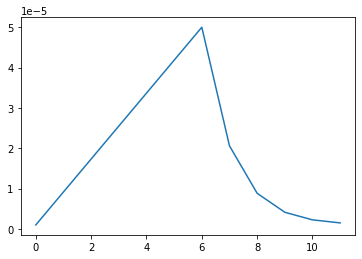

In [18]:
#带warm_up的余弦衰减
LR_START = 0.00000
LR_MAX = 0.00005 
LR_MIN = LR_START = 0.000001
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .4

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


rng = [i for i in range(EPOCHS)]
y_s = [lrfn(x) for x in rng]
print(y_s)
plt.plot(rng, y_s)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y_s[0], max(y_s), y_s[-1]))
lr_warm_up = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

## Load model into the TPU

## Train Model

First, we train on the subset of the training set, which is completely in English.

In [19]:
preds = []
weights = []
models = ["bert-base-uncased","roberta-base","nghuyong/ernie-2.0-en","distilbert-base-uncased","digitalepidemiologylab/covid-twitter-bert-v2"]
for fold,(train,valid) in enumerate(kfold.split(fake_train1.tweet,fake_train1.label)):
    print('#### FOLD',fold+1)
    x_train,x_valid,y_train,y_valid = fake_train1.tweet[train],fake_train1.tweet[valid]\
    ,fake_train1.label[train],fake_train1.label[valid]
    
    tokenizer = AutoTokenizer.from_pretrained(models[fold])
    
    x_fake_train = regular_encode(x_train,tokenizer, maxlen=MAX_LEN)
    x_fake_valid = regular_encode(x_valid,tokenizer,maxlen=MAX_LEN)

    y_fake_train = to_categorical(y_train,2,dtype='int32')
    y_fake_valid = to_categorical(y_valid,2,dtype='int32')
    
    train_dataset = get_train_dataset(x_fake_train,y_fake_train )
    valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
    
    n_steps = x_fake_train.shape[0] // BATCH_SIZE

    # BUILD MODEL
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(models[fold])
        model = build_model(transformer_layer, max_len=MAX_LEN)
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.1, patience = 2, verbose = 2, min_delta = 0.0001, mode = 'max')
    
    train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,sv,lr_warm_up],
    validation_data= valid_dataset,
    epochs=EPOCHS)
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    weights.append(model.evaluate(valid_dataset)[2])
    x_fake_test = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)
    preds.append(model.predict(x_fake_test))
    
    del model

#### FOLD 1




Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
47/47 [==============================] - 37s 785ms/step - f1_score: 0.6827 - loss: 0.5867 - accuracy: 0.6837 - val_f1_score: 0.7344 - val_loss: 0.5049 - val_accuracy: 0.7360 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
47/47 [==============================] - 10s 209ms/step - f1_score: 0.8703 - loss: 0.3039 - accuracy: 0.8705 - val_f1_score: 0.9142 - val_loss: 0.2139 - val_accuracy: 0.9142 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
47/47 [==============================] - 10s 214ms/step - f1_score: 0.9403 - loss: 0.1753 - accuracy: 0.9403 - val_f1_score: 0.9373 - val_loss: 0.1851 - val_accuracy: 0.9373 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
47/47 [==============================] - 10s 213ms/step 



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
47/47 [==============================] - 38s 809ms/step - f1_score: 0.6683 - loss: 0.6237 - accuracy: 0.6690 - val_f1_score: 0.7089 - val_loss: 0.5769 - val_accuracy: 0.7116 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
47/47 [==============================] - 10s 223ms/step - f1_score: 0.7497 - loss: 0.4982 - accuracy: 0.7527 - val_f1_score: 0.8343 - val_loss: 0.3689 - val_accuracy: 0.8363 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
47/47 [==============================] - 10s 223ms/step - f1_score: 0.8994 - loss: 0.2718 - accuracy: 0.8994 - val_f1_score: 0.8826 - val_loss: 0.2998 - val_accuracy: 0.8838 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
47/47 [==============================] - 11s 223ms/step 



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
47/47 [==============================] - 38s 806ms/step - f1_score: 0.7087 - loss: 0.5521 - accuracy: 0.7104 - val_f1_score: 0.8390 - val_loss: 0.3818 - val_accuracy: 0.8389 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
47/47 [==============================] - 10s 210ms/step - f1_score: 0.8915 - loss: 0.2759 - accuracy: 0.8916 - val_f1_score: 0.9252 - val_loss: 0.2010 - val_accuracy: 0.9254 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
47/47 [==============================] - 10s 212ms/step - f1_score: 0.9283 - loss: 0.1911 - accuracy: 0.9284 - val_f1_score: 0.9293 - val_loss: 0.1932 - val_accuracy: 0.9294 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
47/47 [==============================] - 10s 213ms/step 



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
47/47 [==============================] - 22s 473ms/step - f1_score: 0.6508 - loss: 0.6374 - accuracy: 0.6549 - val_f1_score: 0.7434 - val_loss: 0.5359 - val_accuracy: 0.7446 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
47/47 [==============================] - 6s 130ms/step - f1_score: 0.8014 - loss: 0.4152 - accuracy: 0.8020 - val_f1_score: 0.8709 - val_loss: 0.2982 - val_accuracy: 0.8713 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
47/47 [==============================] - 6s 130ms/step - f1_score: 0.9224 - loss: 0.2013 - accuracy: 0.9224 - val_f1_score: 0.9215 - val_loss: 0.1989 - val_accuracy: 0.9215 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
47/47 [==============================] - 6s 132ms/step - f



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
47/47 [==============================] - 91s 2s/step - f1_score: 0.6208 - loss: 0.7970 - accuracy: 0.6207 - val_f1_score: 0.6517 - val_loss: 0.6936 - val_accuracy: 0.6678 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
47/47 [==============================] - 24s 513ms/step - f1_score: 0.8213 - loss: 0.3969 - accuracy: 0.8215 - val_f1_score: 0.8695 - val_loss: 0.3249 - val_accuracy: 0.8705 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
47/47 [==============================] - 25s 524ms/step - f1_score: 0.9242 - loss: 0.2227 - accuracy: 0.9242 - val_f1_score: 0.9505 - val_loss: 0.1668 - val_accuracy: 0.9505 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
47/47 [==============================] - 24s 515ms/step - f

In [20]:
def weight_ensemble(weights,predictions):
    weight_sum = np.sum(weights)  
    prediction_sum = 0
    for i in range(len(weights)):
        prediction_sum += (weights[i]/weight_sum)*predictions[i]
    np.savez('model_predict_weight',prediction_sum)
    result = np.argmax(prediction_sum,axis=1)
    return result

In [21]:
def mean_ensemble(predictions):
    result = np.argmax(np.mean(predictions,axis=0),axis=1)
    np.savez('model_predict_mean',np.mean(predictions,axis=0))
    return result

In [22]:
weight_result= weight_ensemble(weights,preds)
f1_score(np.array(fake_valid1.label,dtype='int32'),weight_result,average='weighted')

0.976621775972256

In [23]:
mean_result = mean_ensemble(preds)
f1=f1_score(np.array(fake_valid1.label,dtype='int32'),mean_result,average='weighted')
f1

0.976621775972256

In [24]:
result = np.argmax(preds[4],axis=1)
f1_score(np.array(fake_valid1.label,dtype='int32'),result,average='weighted')

0.980366972550665

In [25]:
MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
x_fake_valid = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)
x_fake_train = regular_encode(fake_train1.tweet,tokenizer,maxlen=MAX_LEN)



y_fake_train = to_categorical(fake_train1.label,2,dtype='int32')
y_fake_valid = to_categorical(fake_valid1.label,2,dtype='int32')

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()
n_steps = x_fake_train.shape[0] // BATCH_SIZE

train_dataset = get_train_dataset(x_fake_train,y_fake_train)
valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.5, patience = 3, verbose = 1, min_delta = 0.0001, mode = 'max')
sv = tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,lr_warm_up,sv],
    validation_data= valid_dataset,
    epochs=EPOCHS
    )
print('Loading best model...')
model.load_weights('best_model.h5')
x_fake_test = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)
pred = model.predict(x_fake_test)
np.savez('single-%s'%MODEL,pred)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 130)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 130, 1024), (None 335141888 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 335,143,938
Trainable params: 335,143,938
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
59/59 [==============================] - 96s 2s/step - f1_score: 0.6710 - loss: 0.6834 - accuracy: 0.6719 - val_f1_score: 0.7705 - val_loss: 0.4941 - val_accuracy:

FileNotFoundError: [Errno 2] No such file or directory: 'single-digitalepidemiologylab/covid-twitter-bert-v2.npz'

In [26]:
np.mean(predictions,axis=0)
f1_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted')

NameError: name 'predictions' is not defined

In [27]:
submission = pd.DataFrame(columns=['id','label'])
submission.label = result
nlist = range(1,result.shape[0]+1)
submission.id = nlist
submission.to_csv('answer.txt', sep='\t', index=False)